# Generates all plots

### Python imports

In [1]:
import numpy as np
# ===================
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.font_manager
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as clr
import matplotlib.mlab as mlab
# ====================
import copy
import glob
import re
import spiceypy
# ====================
from scipy.stats import norm
import scipy.stats as scipystats

### MATPLOTLIB definitions

In [2]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=14)
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = 7, 0.8*7 # inches, Acta paper width

### Useful function definitions

In [3]:
def _make_gen(reader): # Helper function for efficiently reading large datasets
    b = reader(1024 * 1024)
    while b:
        yield b
        b = reader(1024 * 1024)

def rawgencount(filename):
    f = open(filename, 'rb')
    f_gen = _make_gen(f.raw.read)

    return sum( buf.count(b'\n') for buf in f_gen)

def get_spk_id(str_in):

    m = re.search('threshold_\w+', str_in)
    m = re.search('\_\w+', m.group(0))
    
    if re.search('minus', str_in) is not None:  # Then negative
        
        return "-"+m.group(0)[1:]
    
    return m.group(0)[1:]

### Variable defs

In [4]:
number_of_candidates = []
date_of_study = []
threshold_velocity = []

fname_prefixes = ["threshold/threshold_", "threshold/minus_"]

## Generate candidate threshold plots

### Import data

In [5]:
for directory in fname_prefixes:
    for file in glob.glob(directory+"*"): # basic regex search
        velocity_id = int( get_spk_id(file) )
        date_of_study.append(velocity_id)  # hardcode
        threshold_velocity.append(0.7 + velocity_id * .05)  # 50 m/s increments
        number_of_candidates.append( rawgencount(file) )  # append number of lines (= number of candidates)
        
# Fix offset

offset = np.min(date_of_study)
_tmp = [date+abs(offset) for date in date_of_study]
date_of_study = _tmp

### Sort

In [6]:
permutation_idx = np.argsort(np.array(date_of_study))
threshold_velocity = np.sort(threshold_velocity)
number_of_candidates = np.array(number_of_candidates); number_of_candidates = number_of_candidates[permutation_idx]

### Plot v1

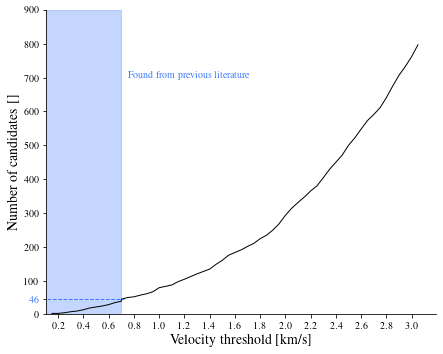

In [7]:
plt.plot(threshold_velocity, number_of_candidates, 'k')
xticks = np.arange(0., np.max(threshold_velocity), 0.2)
plt.xticks(xticks)
plt.yticks(list(plt.yticks()[0]) + [46])

# Labels

plt.xlabel('Velocity threshold [km/s]')
plt.ylabel('Number of candidates []')
plt.xlim(left=0.1)
plt.ylim(bottom=0)

# Shading

plt.axvspan(0., .7, alpha=.3, color='xkcd:lightish blue')  #vertical shading
plt.annotate('Found from previous literature', (.75, 700), color='xkcd:lightish blue')

# Highlight line

plt.axhline(46, xmin=-.05, xmax=.20, linestyle='--', color='xkcd:lightish blue')

plt.gca().get_yticklabels()[-1].set_color("xkcd:lightish blue")

### Plot v2

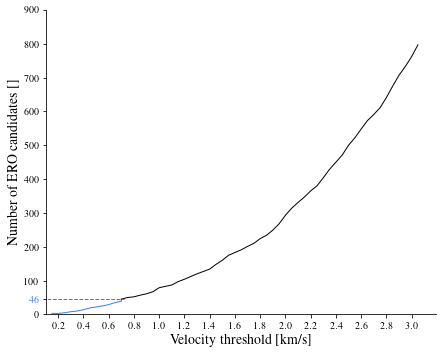

In [8]:
plt.plot(threshold_velocity[0:13], number_of_candidates[0:13], color='xkcd:lightish blue', label='Threshold from previous literature')
plt.plot(threshold_velocity[12:], number_of_candidates[12:], color='k', label='Additional candidates')
xticks = np.arange(0., np.max(threshold_velocity), 0.2)
plt.xticks(xticks)
plt.yticks(list(plt.yticks()[0]) + [46])

# Labels

plt.xlabel('Velocity threshold [km/s]')
plt.ylabel('Number of ERO candidates []')
plt.xlim(left=0.1)
plt.ylim(bottom=0)

# Highlight line

plt.axhline(46, xmin=-.05, xmax=.20, linestyle='--', color='xkcd:lightish blue')

plt.gca().get_yticklabels()[-1].set_color("xkcd:lightish blue")
plt.savefig('plots/cumulative_candidates.pdf')
# plt.legend(loc='upper left')

### Generate prefilter vs time plot

#### Initialise parameters

In [9]:
bodyid = '3410533'
fname = bodyid
spiceypy.furnsh('naif0008.tls')
spiceypy.furnsh('de414.bsp')
spiceypy.furnsh('../ephemeris_files/ephemeris_files/'+bodyid+'.bsp')

#### Load data

In [10]:
data = np.genfromtxt(fname, dtype=float, usecols=(0,1))
orbit_type = np.genfromtxt(fname, dtype='unicode', usecols=(2))
unique, indices = np.unique(orbit_type, return_inverse=True)

#### Compute Jacobi energy

In [11]:
time1 = spiceypy.str2et('Jan 1 2025 00:00')
time2 = spiceypy.str2et('Dec 31 2099 00:00')

times = np.arange(time1, time2, 28 * 86400)

# Get OEs

OEs = np.ndarray((len(times), 8), dtype=float)

for i in range(len(times)):
    time = times[i]
    states = spiceypy.spkezr(bodyid, time, 'ECLIPJ2000', 'None', 'Sun')
    OEs[i,:] = spiceypy.oscelt(states[0], time, 1.32712440018e11)

a = OEs[:,0]/(1-OEs[:,1]) / 1.495978707e8
jacobis = 1/a + 2.0 * np.sqrt(a * (1-OEs[:,1] * np.cos(OEs[:,2])))

#### Plot v1

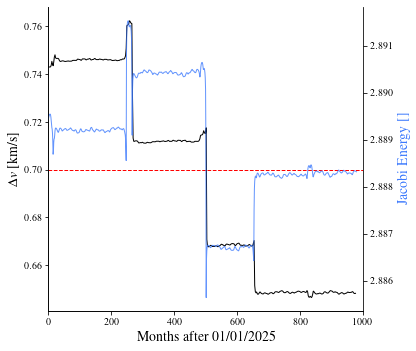

In [12]:
fig = plt.figure()
host = fig.add_subplot(111)
plt.subplots_adjust(right=.75)

par1 = host.twinx()

host.set_xlabel('Months after 01/01/2025')
host.set_ylabel(r'$\Delta v$ [km/s]')

par1.set_ylabel('Jacobi Energy []')

p1,  = host.plot(data[:,0], data[:,1], 'k-', label=r'$\Delta v$ [km/s]')
p2, = par1.plot(jacobis, linestyle='-', color='xkcd:lightish blue', alpha=.8, label='Jacobi Energy')

lns = [p1, p2]

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.gca().spines['right'].set_visible(True)
plt.gca().set_xlim(0, 1000)
host.axhline(y=.7, linestyle='--', color='r')
plt.savefig('plots/3410533_time_behaviour.pdf')

#### Plot v2

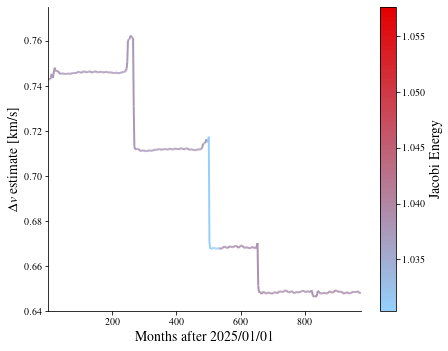

In [13]:
x = data[:,0]
y = data[:,1]
magnitude = a  # first derivative


# Custom colorbar
cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#95d0fc','#e50000'], N=64)

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(magnitude.min(), magnitude.max())
lc = LineCollection(segments, cmap=cmap, norm=norm)
# Set the values used for colormapping
lc.set_array(magnitude)
lc.set_linewidth(2)
line = axs.add_collection(lc)
cbar = fig.colorbar(line, ax=axs)
cbar.set_label('Jacobi Energy')


axs.set_xlabel('Months after 2025/01/01')
axs.set_ylabel(r'$\Delta v$ estimate [km/s]')
axs.set_xlim(x.min(), x.max())
axs.set_ylim(.64, .775)
plt.show()

### Prefilter histograms

#### Load data

In [14]:
# Load SPK IDs of the EROs

eros = np.genfromtxt('extra_candidates/eros', dtype=float)
fname_prefixes = ["threshold/threshold_", "threshold/minus_"]

candidate_lists = {}
bins = {}

for directory in fname_prefixes:
    for file in glob.glob(directory+"*"): # basic regex search
        velocity_id = int( get_spk_id(file) ) + 11
        data = np.genfromtxt(file, dtype=float, skip_header=1, usecols=(0))
        candidate_lists[velocity_id] = data



In [15]:
for key in range(len(candidate_lists.keys())-1):
    actual = candidate_lists[key]
    ref = candidate_lists[key+1]
    bins[(key)*.05] = []
    counter = 0
    
    for candidate in ref:
        if candidate not in actual and candidate in eros:
            counter+=1
    bins[(key)*.05] = counter

velocities = list(bins.keys())
candidates = list(bins.values())

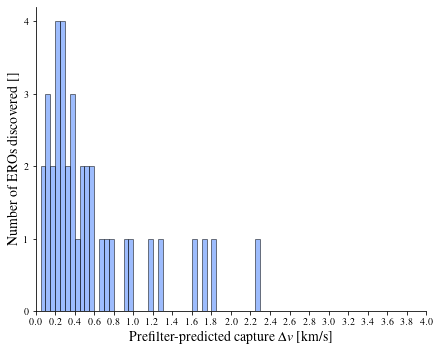

In [16]:
plt.bar(velocities, candidates, color='xkcd:lightish blue', alpha=.5, align='edge', width=.05, edgecolor='k')
plt.xlabel('Prefilter-predicted capture $\Delta v$ [km/s]')
plt.ylabel('Number of EROs discovered []')
plt.xticks(np.arange(np.min(velocities), 4.1, .2))
plt.yticks(np.unique(candidates))
plt.xlim((0, 4.0))
plt.savefig('plots/EROs_by_velocity.pdf')

### Add normal distribution to plot

[1.51729691 0.36930706]


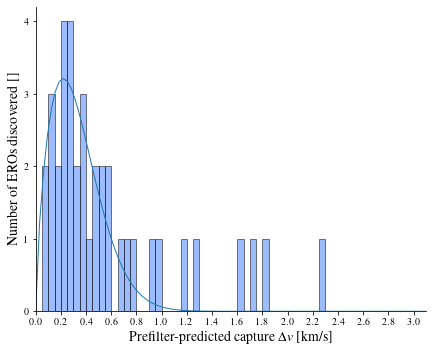

In [17]:
from scipy.optimize import curve_fit


plt.bar(velocities, candidates, color='xkcd:lightish blue', alpha=.5, align='edge', width=.05, edgecolor='k')
plt.xlabel('Prefilter-predicted capture $\Delta v$ [km/s]')
plt.ylabel('Number of EROs discovered []')
plt.xticks(np.arange(np.min(velocities), 3.1, .2))
plt.yticks(np.unique(candidates))
plt.xlim((0, 3.1))

# fit bar plot data using curve_fit
def func(x, a, b):
    # a Gaussian distribution
    gamma = 1.7
    return a * gamma/b * (x/b)**(gamma-1) * np.exp(-(x/b)**gamma)

def pert(x, a=0, b=10., c=100):
    big_b = gam(a) * gam(b) / (gam(a + b))
    alpha = 1 + 4. * (b-a)/(c-a)
    beta = 1 + 4. * (c-b)/(c-a)
    
    return ( (x-a) ** (alpha-1) * (c-x) ** (beta-1) ) / ( big_b * (c-a) ** (alpha+beta-1) )

popt, pcov = curve_fit(func, velocities, candidates)
print(popt)
xmin, xmax = plt.xlim()
x_range = np.linspace(xmin, xmax, 100)
to_plot = func(x_range, *popt)
# scale_factor = np.max(candidates)/np.max(to_plot)
plt.plot(x_range, func(x_range, *popt))
plt.xlim((0, 3.1))
plt.savefig('plots/EROs_by_velocity_with_distribution.pdf')

### Distribution is shitty and needs work but c'est la vie

### Sanchez comparison plot

In [18]:
sanchez_comparison = np.genfromtxt('sanchez_comparison', skip_header=1, usecols=(1,2), dtype=float, delimiter=',')

In [19]:
difference = sanchez_comparison[:,0] - sanchez_comparison[:,1]

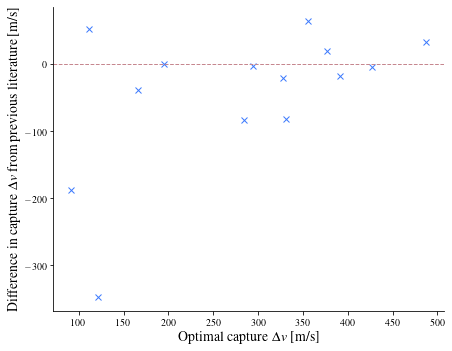

In [20]:
plt.scatter(sanchez_comparison[:,0], difference, color='xkcd:lightish blue', marker='x')
plt.xlabel('Optimal capture $\Delta v$ [m/s]')
plt.ylabel('Difference in capture $\Delta v$ from previous literature [m/s]')
plt.axhline(y=0, linestyle='--', color='#C6878F')
plt.savefig('plots/sanchez_comparison_scatter.pdf')

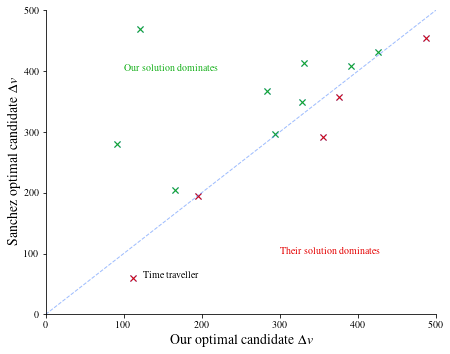

In [21]:
plt.scatter(sanchez_comparison[:,0], sanchez_comparison[:,1], color='xkcd:lightish blue', marker='x')
plt.xlim(0, 501)
plt.ylim(0, 501)
plt.xlabel('Our optimal candidate $\Delta v$')
plt.ylabel('Sanchez optimal candidate $\Delta v$')

above = sanchez_comparison[sanchez_comparison[:,0]>sanchez_comparison[:,1], :]
below = sanchez_comparison[sanchez_comparison[:,1]>sanchez_comparison[:,0], :]


plt.scatter(above[:,0], above[:,1], color='xkcd:red', marker='x')
plt.scatter(below[:,0], below[:,1], color='xkcd:green', marker='x')

# Plot y=x
x = np.arange(0, 501, 0.1)
y = x
plt.plot(x, y, color='xkcd:lightish blue', linestyle='--', alpha=.5)
plt.annotate( 'Our solution dominates', (100, 400), color='xkcd:green')
plt.annotate( 'Their solution dominates', (300, 100), color='xkcd:red')
plt.annotate( 'Time traveller', (125, 60), color='k');
plt.savefig('plots/sanchez_comparison_scatter_diagonal.pdf')

#### Mean velocity difference

In [22]:
print("Mean velocity difference = " + str(np.mean(difference)) +' m/s')

Mean velocity difference = -43.83142857142856 m/s


#### Sigma

In [23]:
print("Standard deviation = " + str(np.std(difference)) + ' m/s')

Standard deviation = 105.03529487456946 m/s


### Prefilter vs optimiser figure

In [24]:
prefilter_velocities = np.genfromtxt('week_1', skip_header=1, usecols=(0, 1), dtype=float)
optimiser_velocities = np.genfromtxt('eros', dtype=float, usecols=(0, 1))

In [25]:
# Check
np.all(prefilter_velocities[:,0] == optimiser_velocities[:,0])

True

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


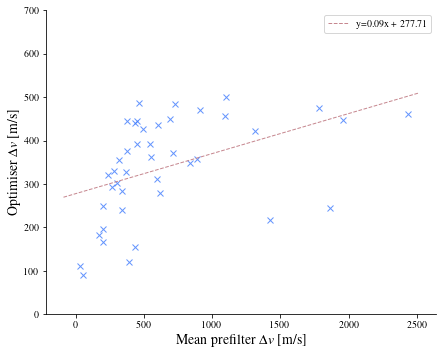

In [26]:
plt.scatter(prefilter_velocities[:,1]*1000.0, optimiser_velocities[:,1]*1000, color='xkcd:lightish blue', alpha=.8, marker='x')
plt.xlabel('Mean prefilter $\Delta v$ [m/s]')
plt.ylabel('Optimiser $\Delta v$ [m/s]')
plt.ylim(0, 701)
# Fit
p = np.polyfit(prefilter_velocities[:,1]*1000.0, optimiser_velocities[:,1]*1000, 1)
xmin, xmax = plt.xlim()
x = np.arange(xmin, xmax, 100)
y = p[0] * x + p[1]
plt.plot(x, y, label=f"y={p[0]:3.2f}x + {p[1]:3.2f}", color='#C6878F', linestyle='--')
plt.legend()
plt.savefig('plots/optimiser_vs_prefilter_scatter.pdf')

#### Mean difference between optimiser and prefilter results

In [27]:
print("Mean velocity difference (prefilter-optimiser): " + str(np.mean(prefilter_velocities[:30,1] * 1000. - optimiser_velocities[:30,1])) + "m/s.\nSigma in velocity difference: " + str(np.std(prefilter_velocities[:30,1] * 1000. - optimiser_velocities[:30,1])) + "m/s.")

Mean velocity difference (prefilter-optimiser): 383.6018446885651m/s.
Sigma in velocity difference: 171.3652895543608m/s.


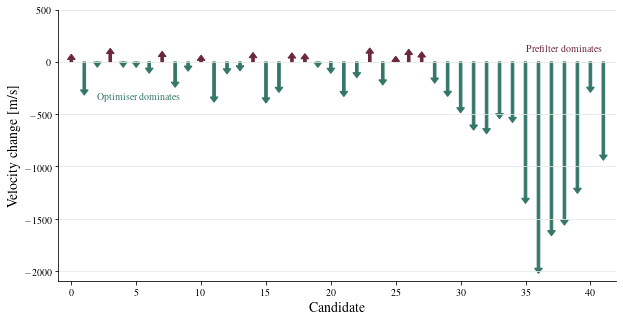

In [28]:
#initialize a plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(-2,len(prefilter_velocities[:,0]))
ax.set_ylim(-2100., 500.)

#define arrows
arrow_starts = np.repeat(0, len(prefilter_velocities[:,1]))
arrow_lengths = optimiser_velocities[:,1]*1000. - prefilter_velocities[:,1]*1000.

#add arrows to plot
for i, subject in enumerate(prefilter_velocities[:,1]):
    
    if arrow_lengths[i] < 0:
        arrow_color = '#347768' # Green-ish
    elif arrow_lengths[i] > 0:
        arrow_color = '#6B273D' # Red-ish
    
    ax.arrow(i,
             arrow_starts[i],
             0.,
             arrow_lengths[i],
             head_width=0.6,
             head_length=50,
             width=0.2,
             fc=arrow_color,
             ec=arrow_color)
    
#format plot
ax.grid(axis='y', color='0.9')
ax.set_xlim(-1, len(prefilter_velocities[:,0]))
ax.set_xlabel('Candidate')
ax.set_ylabel('Velocity change [m/s]')
ax.annotate('Optimiser dominates', (2, -350), color='#347768')
ax.annotate('Prefilter dominates', (35, 100), color='#6B273D')
plt.savefig('plots/optimiser_vs_prefilter_arrows.pdf')

### Zoomed-in version of the above

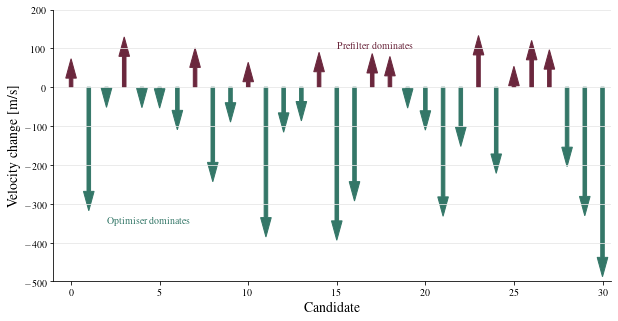

In [29]:
#initialize a plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(-2,len(prefilter_velocities[:,0]))
ax.set_ylim(-500., 200.)

#define arrows
arrow_starts = np.repeat(0, len(prefilter_velocities[:,1]))
arrow_lengths = optimiser_velocities[:,1]*1000. - prefilter_velocities[:,1]*1000.

#add arrows to plot
for i, subject in enumerate(prefilter_velocities[:,1]):
    
    if arrow_lengths[i] < 0:
        arrow_color = '#347768'
    elif arrow_lengths[i] > 0:
        arrow_color = '#6B273D'
    
    ax.arrow(i,
             arrow_starts[i],
             0.,
             arrow_lengths[i],
             head_width=0.6,
             head_length=50,
             width=0.2,
             fc=arrow_color,
             ec=arrow_color)
    
#format plot
ax.grid(axis='y', color='0.9')
ax.set_xlim(-1, 30.5)
ax.set_xlabel('Candidate')
ax.set_ylabel('Velocity change [m/s]')
ax.annotate('Optimiser dominates', (2, -350), color='#347768')
ax.annotate('Prefilter dominates', (15, 100), color='#6B273D')
plt.savefig('plots/optimiser_vs_prefilter_arrows_zoomed.pdf')

### Observe local solutions

In [30]:
local_solution = []
transfer_time = []

for file in glob.glob("form_pareto/3390109*"):
    transfer_time.append(int(file.split('_')[-1]))
    data = np.genfromtxt(file, usecols=(0), dtype=float)
    local_solution.append(np.min(data))


1059


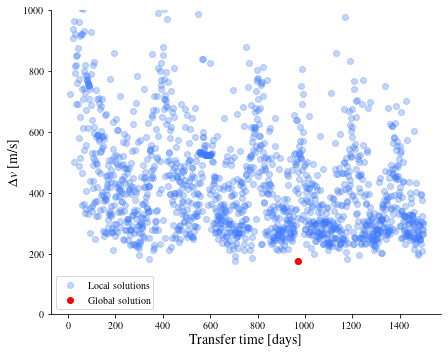

In [31]:
## Sort the transfer time

transfer_time = np.array(transfer_time); local_solution = np.array(local_solution)
permutation_matrix = np.argsort(transfer_time)
transfer_time = transfer_time[permutation_matrix]
local_solution = local_solution[permutation_matrix]

## Plot

plt.plot(transfer_time, local_solution*1000, linestyle='None', marker='o', color='xkcd:lightish blue', alpha=.3, label='Local solutions')
plt.xlabel('Transfer time [days]')
plt.ylabel('$\Delta v$ [m/s]')
plt.ylim((0.00, 1000.))

# Find the minimum point and plot it
minimum_point = np.argmin(local_solution)
plt.plot(transfer_time[minimum_point], local_solution[minimum_point]*1000, 'ro', label='Global solution')
# plt.title('3995816')
plt.legend(loc='lower left')
plt.savefig('plots/pareto_front_3390109.pdf')

print(np.sum(local_solution < .5))

### EROs for a given threshold

In [32]:
threshold_data = np.genfromtxt('../results/all_table.tex', skip_header=3, usecols=(0, 2), skip_footer=1)

count = 0
for element in range(len(threshold_data[:,1])):
    if threshold_data[element,1] > 500 and threshold_data[element,1] < 600:
        count += 1
print(count)

21


### Optimisation procedure figure

## Results tables

### Original EROs - 700m/s prefilter limit

#### EROs found

| SPK ID  | $$\Delta v [m/s]$$ | Transfer epoch       | Transfer end         | Arrival at periodic orbit | Orbit family         |
|---------|-----------------------|----------------------|----------------------|---------------------------|----------------------|
    | 3005816 | 487\\.63               | 2029 JUN 01 12:11:59 | 2032 MAR 15 23:13:36 | 2036 MAR 08 06:59:14      | L2 Northern Halo     |
    | 3054374 | 121\\.29               | 2061 DEC 08 23:45:51 | 2065 FEB 07 02:55:23 | 2065 DEC 30 10:34:47      | L1 Planar            |
    | 3390109 | 195\\.58               | 2041 JUL 17 06:29:40 | 2045 JAN 07 08:18:40 | 2048 JAN 19 09:58:11      | L2 Vertical Lyapunov |
    | 3403148 | 111\\.61               | 2052 FEB 20 02:05:41 | 2055 NOV 10 03:24:57 | 2059 SEP 09 07:07:04      | L1 Northern Halo     |
    | 3405189 | 376\\.61               | 2027 MAR 31 04:24:25 | 2029 MAR 16 19:10:30 | 2026 JAN 03 17:27:36      | L2 Planar            |
    | 3405338 | 303\\.06               | 2097 JUN 10 19:31:39 | 2100 NOV 13 07:34:10 | 2103 AUG 17 00:17:37      | L2 Northern Halo     |
    | 3435539 | 284\\.26               | 2050 SEP 23 15:23:02 | 2053 OCT 04 12:40:26 | 2056 DEC 31 14:32:26      | L2 Planar            |
    | 3444297 | 330\\.95               | 2073 JAN 06 04:12:46 | 2075 AUG 22 02:42:28 | 2077 DEC 18 13:49:20      | L2 Vertical Lyapunov |
    | 3549639 | 362\\.47               | 2029 FEB 16 15:17:40 | 2032 SEP 09 11:46:57 | 2031 JAN 22 09:37:52      | L1 Planar            |
    | 3550232 | 328\\.29               | 2092 NOV 09 14:39:59 | 2095 AUG 27 19:38:33 | 2099 MAY 22 01:43:43      | L2 Vertical Lyapunov |
    | 3551168 | 183\\.46               | 2034 JUL 07 05:25:05 | 2038 MAR 26 23:07:07 | 2038 JUN 01 05:28:20      | L2 Vertical Lyapunov |
    | 3556127 | 280\\.44               | 2045 APR 01 07:07:17 | 2048 FEB 07 20:33:34 | 2048 JUL 09 12:06:04      | L1 Planar            |
    | 3568303 | 426\\.57               | 2064 APR 26 07:09:57 | 2066 MAY 13 10:45:10 | 2066 DEC 15 07:11:16      | L2 Vertical Lyapunov |
    | 3582145 | 166\\.17               | 2038 JAN 07 13:33:13 | 2040 MAY 23 05:10:35 | 2040 AUG 02 13:51:54      | L2 Vertical Lyapunov |
    | 3610175 | 91\\.62                | 2097 JUN 15 08:56:27 | 2100 NOV 19 18:57:56 | 2103 NOV 21 09:54:12      | L2 Vertical Lyapunov |
    | 3618493 | 375\\.15               | 2056 NOV 20 11:16:06 | 2059 NOV 08 10:35:32 | 2063 OCT 25 18:14:36      | L1 Planar            |
    | 3625129 | 448\\.96               | 2076 MAR 03 06:40:20 | 2079 JUN 05 22:52:32 | 2080 MAY 30 06:45:05      | L1 Planar            |
    | 3648046 | 356\\.02               | 2047 JAN 11 20:21:19 | 2049 SEP 26 06:42:49 | 2051 APR 11 03:02:14      | L2 Vertical Lyapunov |
    | 3698849 | 294\\.23               | 2065 FEB 03 18:04:53 | 2068 MAY 10 11:12:59 | 2069 APR 28 02:06:52      | L2 Southern Halo     |
    | 3719859 | 445\\.60               | 2043 MAR 06 06:16:12 | 2046 SEP 01 15:22:48 | 2047 JUL 19 03:56:13      | L2 Southern Halo     |
    | 3726012 | 391\\.48               | 2031 APR 13 09:32:10 | 2034 JUL 05 06:45:59 | 2037 OCT 18 19:16:18      | L2 Vertical Lyapunov |
    | 3733264 | 154\\.19               | 2099 DEC 28 03:43:38 | 2103 JUL 12 14:32:41 | 2102 DEC 04 11:41:18      | L2 Vertical Lyapunov |
    | 3759358 | 250\\.83               | 2059 OCT 01 22:16:51 | 2062 JUN 21 21:26:20 | 2065 FEB 14 15:11:02      | L2 Vertical Lyapunov |
    | 3781977 | 320\\.69               | 2071 NOV 28 11:32:55 | 2074 NOV 22 16:29:30 | 2074 DEC 18 18:31:38      | L2 Vertical Lyapunov |
    | 3826850 | 435\\.39               | 2087 OCT 14 12:16:56 | 2090 APR 11 16:32:09 | 2089 JUL 28 07:30:45      | L1 Planar            |
    | 3840784 | 440\\.79               | 2073 OCT 20 17:55:10 | 2076 SEP 27 17:58:09 | 2076 DEC 17 03:43:52      | L1 Vertical Lyapunov |
    | 3843512 | 445\\.08               | 2053 AUG 04 14:41:07 | 2056 DEC 10 04:58:32 | 2058 JUL 22 22:12:32      | L2 Southern Halo     |
    | 3843865 | 251\\.61               | 2034 OCT 22 21:02:06 | 2038 FEB 15 08:37:22 | 2037 MAR 03 21:00:41      | L2 Northern Halo     |
    | 3893945 | 451\\.59               | 2093 JAN 31 01:43:25 | 2094 SEP 11 00:11:30 | 2095 APR 11 22:28:06      | L2 Vertical Lyapunov |
    | 3989308 | 311\\.72               | 2065 FEB 18 00:17:39 | 2065 JUL 07 22:46:21 | 2065 JUL 10 22:20:35      | L1 Planar            |

#### Comparison with Sanchez

| SPK ID  | Our $$\Delta v$$ [m/s] | Sanchez $$\Delta v$$ |
|---------|-----------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 3005816 | 487\.63                                       | 454                                                                                                                                                                                       |
| 3054374 | 121\.29                                       | 470                                                                                                                                                                                       |
| 3332535 | Does not pass prefilter                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3339082 | Does not pass prefilter                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3390109 | 195\.58                                       | 195                                                                                                                                                                                       |
| 3403148 | 111\.61                                       | 59 \(odd\)                                                                                                                                                                                |
| 3405189 | 376\.61                                       | 357                                                                                                                                                                                       |
| 3405338 | 303\.06                                       | Does not pass prefilter                                                                                                                                                                   |
| 3435539 | 284\.26                                       | 367                                                                                                                                                                                       |
| 3444297 | 330\.95                                       | 413                                                                                                                                                                                       |
| 3520667 | Does not pass prefilter                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3549639 | 362\.47                                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3550232 | 328\.29                                       | 349                                                                                                                                                                                       |
| 3551168 | 183\.46                                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3556125 | Passes prefilter: does not become ERO \(606\) | 451                                                                                                                                                                                       |
| 3556127 | 280\.44                                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3568303 | 426\.57                                       | 431                                                                                                                                                                                       |
| 3582145 | 166\.17                                       | 204                                                                                                                                                                                       |
| 3610175 | 91\.62                                        | 280                                                                                                                                                                                       |
| 3618493 | 375\.15                                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3625129 | 448\.96                                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3634612 | Does not pass prefilter                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3648046 | 356\.02                                       | 291                                                                                                                                                                                       |
| 3698849 | 294\.23                                       | 297                                                                                                                                                                                       |
| 3719859 | 445\.60                                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3719226 | Does not pass prefilter                       | Passes prefilter: does not become ERO|
| 3726012 | 391\.48                                       | 409                                                                                                                                                                                       |
| 3733264 | 154\.19                                       | Passes prefilter: does not become ERO                                                                                                                                                     |
| 3759358 | 250\.83                                       | Not available at time of study                                                                                                                                                            |
| 3781977 | 320\.69                                       | Not available at time of study                                                                                                                                                            |
| 3826850 | 435\.39                                       | Not available at time of study                                                                                                                                                            |
| 3840784 | 440\.79                                       | Not available at time of study                                                                                                                                                            |
| 3843512 | 445\.08                                       | Not available at time of study                                                                                                                                                            |
| 3843865 | 251\.61                                       | Not available at time of study                                                                                                                                                            |
| 3893945 | 451\.59                                       | Not available at time of study                                                                                                                                                            |
| 3989308 | 311\.72                                       | Not available at time of study                                                                                                                                                            |


#### All transfers (ie includes non-EROs)

| SPK ID  | $$\Delta v$$ \[m/s\] | Transfer epoch       | Transfer end         | Arrival at periodic orbit | Orbit family         | In $\pi/8$ plane? |
|---------|-----------------------|----------------------|----------------------|---------------------------|----------------------|--------------------|
| 3005816 | 487\.63               | 2029 JUN 01 12:11:59 | 2032 MAR 15 23:13:36 | 2036 MAR 08 06:59:14      | L2 Northern Halo     | No                 |
| 3054374 | 121\.29               | 2061 DEC 08 23:45:51 | 2065 FEB 07 02:55:23 | 2065 DEC 30 10:34:47      | L1 Planar            | No                 |
| 3076774 | 557\.67               | 2084 NOV 24 11:26:24 | 2087 OCT 29 17:46:27 | 2088 NOV 14 23:16:10      | L2 Northern Halo     | No                 |
| 3390109 | 195\.58               | 2041 JUL 17 06:29:40 | 2045 JAN 07 08:18:40 | 2048 JAN 19 09:58:11      | L2 Vertical Lyapunov | No                 |
| 3403148 | 111\.61               | 2052 FEB 20 02:05:41 | 2055 NOV 10 03:24:57 | 2059 SEP 09 07:07:04      | L1 Northern Halo     | No                 |
| 3405189 | 376\.61               | 2027 MAR 31 04:24:25 | 2029 MAR 16 19:10:30 | 2026 JAN 03 17:27:36      | L2 Planar            | No                 |
| 3405338 | 303\.06               | 2097 JUN 10 19:31:39 | 2100 NOV 13 07:34:10 | 2103 AUG 17 00:17:37      | L2 Northern Halo     | No                 |
| 3409707 | 526\.93               | 2042 NOV 18 19:49:41 | 2046 JUL 14 23:44:52 | 2049 MAR 16 14:06:37      | L2 Vertical Lyapunov | No                 |
| 3410533 | 536\.02               | 2058 DEC 07 19:41:30 | 2062 AUG 23 23:02:39 | 2064 MAR 22 20:32:35      | L2 Vertical Lyapunov | No                 |
| 3435539 | 284\.26               | 2050 SEP 23 15:23:02 | 2053 OCT 04 12:40:26 | 2056 DEC 31 14:32:26      | L2 Planar            | No                 |
| 3444297 | 330\.95               | 2073 JAN 06 04:12:46 | 2075 AUG 22 02:42:28 | 2077 DEC 18 13:49:20      | L2 Vertical Lyapunov | No                 |
| 3549639 | 362\.47               | 2029 FEB 16 15:17:40 | 2032 SEP 09 11:46:57 | 2031 JAN 22 09:37:52      | L1 Planar            | No                 |
| 3550232 | 328\.29               | 2092 NOV 09 14:39:59 | 2095 AUG 27 19:38:33 | 2099 MAY 22 01:43:43      | L2 Vertical Lyapunov | No                 |
| 3551168 | 183\.46               | 2034 JUL 07 05:25:05 | 2038 MAR 26 23:07:07 | 2038 JUN 01 05:28:20      | L2 Vertical Lyapunov | No                 |
| 3556125 | 636\.00               | 2044 MAY 03 19:46:22 | 2047 JUN 18 09:59:40 | 2045 DEC 14 18:07:56      | L2 Vertical Lyapunov | No                 |
| 3556127 | 280\.44               | 2045 APR 01 07:07:17 | 2048 FEB 07 20:33:34 | 2048 JUL 09 12:06:04      | L1 Planar            | No                 |
| 3568303 | 426\.57               | 2064 APR 26 07:09:57 | 2066 MAY 13 10:45:10 | 2066 DEC 15 07:11:16      | L2 Vertical Lyapunov | No                 |
| 3582145 | 166\.17               | 2038 JAN 07 13:33:13 | 2040 MAY 23 05:10:35 | 2040 AUG 02 13:51:54      | L2 Vertical Lyapunov | No                 |
| 3605334 | 685\.49               | 2087 SEP 01 16:28:48 | 2090 OCT 14 14:33:26 | 2090 DEC 08 16:01:46      | L2 Vertical Lyapunov | No                 |
| 3610175 | 91\.62                | 2097 JUN 15 08:56:27 | 2100 NOV 19 18:57:56 | 2103 NOV 21 09:54:12      | L2 Vertical Lyapunov | No                 |
| 3618493 | 375\.15               | 2056 NOV 20 11:16:06 | 2059 NOV 08 10:35:32 | 2063 OCT 25 18:14:36      | L1 Planar            | No                 |
| 3625129 | 448\.96               | 2076 MAR 03 06:40:20 | 2079 JUN 05 22:52:32 | 2080 MAY 30 06:45:05      | L1 Planar            | No                 |
| 3648046 | 356\.02               | 2047 JAN 11 20:21:19 | 2049 SEP 26 06:42:49 | 2051 APR 11 03:02:14      | L2 Vertical Lyapunov | No                 |
| 3683393 | 633\.19               | 2070 JAN 23 19:07:02 | 2073 MAR 07 06:31:54 | 2075 OCT 19 18:34:17      | L2 Vertical Lyapunov | No                 |
| 3697803 | 583\.97               | 2028 JAN 15 04:32:45 | 2031 FEB 16 15:45:27 | 2034 JUL 02 12:20:55      | L2 Southern Halo     | No                 |
| 3698849 | 294\.23               | 2065 FEB 03 18:04:53 | 2068 MAY 10 11:12:59 | 2069 APR 28 02:06:52      | L2 Southern Halo     | No                 |
| 3699893 | 519\.42               | 2068 SEP 24 07:24:06 | 2069 JUN 04 18:18:26 | 2070 NOV 07 11:34:40      | L2 Vertical Lyapunov | Yes                |
| 3719226 | 602\.89               | 2073 JAN 21 01:16:26 | 2075 OCT 02 05:40:24 | 2076 SEP 28 23:12:10      | L2 Vertical Lyapunov | No                 |
| 3719859 | 445\.60               | 2043 MAR 06 06:16:12 | 2046 SEP 01 15:22:48 | 2047 JUL 19 03:56:13      | L2 Southern Halo     | No                 |
| 3726012 | 391\.48               | 2031 APR 13 09:32:10 | 2034 JUL 05 06:45:59 | 2037 OCT 18 19:16:18      | L2 Vertical Lyapunov | No                 |
| 3733264 | 154\.19               | 2099 DEC 28 03:43:38 | 2103 JUL 12 14:32:41 | 2102 DEC 04 11:41:18      | L2 Vertical Lyapunov | No                 |
| 3736815 | 731\.41               | 2051 AUG 18 15:18:12 | 2054 DEC 06 23:27:22 | 2055 AUG 19 18:58:14      | L2 Vertical Lyapunov | No                 |
| 3759358 | 250\.83               | 2059 OCT 01 22:16:51 | 2062 JUN 21 21:26:20 | 2065 FEB 14 15:11:02      | L2 Vertical Lyapunov | No                 |
| 3767925 | 561\.69               | 2084 JUL 04 13:25:32 | 2087 JAN 04 01:57:47 | 2087 FEB 04 21:04:12      | L2 Vertical Lyapunov | No                 |
| 3773057 | 543\.91               | 2063 MAR 27 07:30:51 | 2065 MAY 16 10:44:43 | 2061 DEC 15 08:43:59      | L2 Southern Halo     | No                 |
| 3781977 | 320\.69               | 2071 NOV 28 11:32:55 | 2074 NOV 22 16:29:30 | 2074 DEC 18 18:31:38      | L2 Vertical Lyapunov | No                 |
| 3785773 | 601\.01               | 2088 JUL 16 21:04:44 | 2091 MAY 20 11:07:36 | 2093 SEP 05 01:08:30      | L2 Vertical Lyapunov | No                 |
| 3826775 | 740\.82               | 2044 JUN 27 23:30:17 | 2047 JUL 04 00:34:47 | 2048 FEB 26 01:54:48      | L1 Southern Halo     | No                 |
| 3826850 | 435\.39               | 2087 OCT 14 12:16:56 | 2090 APR 11 16:32:09 | 2089 JUL 28 07:30:45      | L1 Planar            | No                 |
| 3831863 | 649\.14               | 2070 JAN 03 05:11:42 | 2073 DEC 10 23:30:56 | 2073 SEP 01 05:11:30      | L2 Northern Halo     | No                 |
| 3836309 | 567\.22               | 2067 FEB 08 19:01:27 | 2068 SEP 19 21:37:23 | 2070 JAN 22 22:29:46      | L2 Southern Halo     | No                 |
| 3840784 | 440\.79               | 2073 OCT 20 17:55:10 | 2076 SEP 27 17:58:09 | 2076 DEC 17 03:43:52      | L1 Vertical Lyapunov | No                 |
| 3843512 | 445\.08               | 2053 AUG 04 14:41:07 | 2056 DEC 10 04:58:32 | 2058 JUL 22 22:12:32      | L2 Southern Halo     | No                 |
| 3843865 | 251\.61               | 2034 OCT 22 21:02:06 | 2038 FEB 15 08:37:22 | 2037 MAR 03 21:00:41      | L2 Northern Halo     | No                 |
| 3893945 | 451\.59               | 2093 JAN 31 01:43:25 | 2094 SEP 11 00:11:30 | 2095 APR 11 22:28:06      | L2 Vertical Lyapunov | No                 |
| 3989308 | 311\.72               | 2065 FEB 18 00:17:39 | 2065 JUL 07 22:46:21 | 2065 JUL 10 22:20:35      | L1 Planar            | No                 |


### 'Extra' EROs - prefilter threshold 3km/s

#### Additional Candidates found when raising threshold to 1000m/s

| SPK ID | $$\Delta v [m/s]$$ | Transfer epoch | Transfer end | Arrival at periodic orbit | Orbit family |
|--------------------|---------------------------------|----------------------------|--------------------------|---------------------------------------|--------------------------|
| 3618493  | 370\.56                         | 2056 NOV 27 11:43:45       | 2059 NOV 03 07:51:56     | 2063 OCT 26 15:37:34                  | L1 Planar                |
| 3702319            | 347\.90                         | 2090 NOV 12 23:18:01       | 2094 JAN 17 06:58:06     | 2094 APR 02 18:45:39                  | L2 Vertical Lyapunov     |
| 3735181            | 358\.02                         | 2094 JUN 20 08:38:08       | 2098 MAR 27 06:07:11     | 2102 JAN 08 20:57:28                  | L1 Planar                |
| 3879383            | 484\.81                         | 2089 JUL 11 18:33:10       | 2093 FEB 01 10:47:56     | 2094 SEP 01 12:52:36                  | L2 Vertical Lyapunov     |


#### All EROs for threshold = 3000m/s

| SPK ID  | $$\Delta v [m/s]$$ | Transfer epoch       | Transfer end         | Arrival at periodic orbit | Orbit family         |
|---------|---------------------|----------------------|----------------------|---------------------------|----------------------|
| 3005816 | 487\.63             | 2029 JUN 01 12:11:59 | 2032 MAR 15 23:13:36 | 2036 MAR 08 06:59:14      | L2 Northern Halo     |
| 3054374 | 121\.29             | 2061 DEC 08 23:45:51 | 2065 FEB 07 02:55:23 | 2065 DEC 30 10:34:47      | L1 Planar            |
| 3315004 | 470\.25             | 2073 DEC 05 05:08:32 | 2075 NOV 21 19:12:30 | 2076 JUN 16 07:14:25      | L2 Vertical Lyapunov |
| 3390109 | 195\.58             | 2041 JUL 17 06:29:40 | 2045 JAN 07 08:18:40 | 2048 JAN 19 09:58:11      | L2 Vertical Lyapunov |
| 3403148 | 111\.61             | 2052 FEB 20 02:05:41 | 2055 NOV 10 03:24:57 | 2059 SEP 09 07:07:04      | L1 Northern Halo     |
| 3405189 | 376\.61             | 2027 MAR 31 04:24:25 | 2029 MAR 16 19:10:30 | 2026 JAN 03 17:27:36      | L2 Planar            |
| 3405338 | 303\.06             | 2097 JUN 10 19:31:39 | 2100 NOV 13 07:34:10 | 2103 AUG 17 00:17:37      | L2 Northern Halo     |
| 3435539 | 284\.26             | 2050 SEP 23 15:23:02 | 2053 OCT 04 12:40:26 | 2056 DEC 31 14:32:26      | L2 Planar            |
| 3444297 | 330\.95             | 2073 JAN 06 04:12:46 | 2075 AUG 22 02:42:28 | 2077 DEC 18 13:49:20      | L2 Vertical Lyapunov |
| 3519518 | 499\.76             | 2073 DEC 01 10:41:50 | 2076 DEC 05 08:21:46 | 2079 AUG 26 20:47:33      | L1 Planar            |
| 3549639 | 362\.46             | 2029 FEB 17 02:08:41 | 2032 SEP 09 11:41:07 | 2034 APR 28 12:48:44      | L1 Planar            |
| 3550232 | 328\.29             | 2092 NOV 09 14:39:59 | 2095 AUG 27 19:38:33 | 2099 MAY 22 01:43:43      | L2 Vertical Lyapunov |
| 3551168 | 183\.46             | 2034 JUL 07 05:25:05 | 2038 MAR 26 23:07:07 | 2038 JUN 01 05:28:20      | L2 Vertical Lyapunov |
| 3556127 | 280\.44             | 2045 APR 01 07:07:17 | 2048 FEB 07 20:33:34 | 2048 JUL 09 12:06:04      | L1 Planar            |
| 3568303 | 426\.57             | 2064 APR 26 07:09:57 | 2066 MAY 13 10:45:10 | 2066 DEC 15 07:11:16      | L2 Vertical Lyapunov |
| 3582145 | 166\.17             | 2038 JAN 07 13:33:13 | 2040 MAY 23 05:10:35 | 2040 AUG 02 13:51:54      | L2 Vertical Lyapunov |
| 3610175 | 91\.62              | 2097 JUN 15 08:56:27 | 2100 NOV 19 18:57:56 | 2103 NOV 21 09:54:12      | L2 Vertical Lyapunov |
| 3618493 | 370\.56             | 2056 NOV 27 11:43:45 | 2059 NOV 03 07:51:56 | 2063 OCT 26 15:37:34      | L1 Planar            |
| 3625129 | 448\.96             | 2076 MAR 03 06:40:20 | 2079 JUN 05 22:52:32 | 2080 MAY 30 06:45:05      | L1 Planar            |
| 3648046 | 356\.02             | 2047 JAN 11 20:21:19 | 2049 SEP 26 06:42:49 | 2051 APR 11 03:02:14      | L2 Vertical Lyapunov |
| 3696401 | 457\.29             | 2053 MAR 03 17:18:13 | 2056 OCT 12 00:34:07 | 2058 AUG 24 16:12:04      | L1 Planar            |
| 3698849 | 293\.65             | 2068 APR 09 23:32:42 | 2069 MAY 17 10:38:58 | 2070 APR 26 03:18:33      | L2 Southern Halo     |
| 3702319 | 347\.66             | 2090 NOV 13 06:04:30 | 2094 JAN 11 02:27:49 | 2094 APR 02 14:00:04      | L2 Vertical Lyapunov |
| 3719859 | 445\.51             | 2043 MAR 06 12:03:50 | 2046 SEP 01 13:26:16 | 2047 JUL 19 03:24:35      | L2 Southern Halo     |
| 3726012 | 391\.48             | 2031 APR 13 09:32:10 | 2034 JUL 05 06:45:59 | 2037 OCT 18 19:16:18      | L2 Vertical Lyapunov |
| 3733264 | 154\.19             | 2099 DEC 28 03:43:38 | 2103 JUL 12 14:32:41 | 2102 DEC 04 11:41:18      | L2 Vertical Lyapunov |
| 3735181 | 358\.02             | 2094 JUN 20 08:38:08 | 2098 MAR 27 06:07:11 | 2102 JAN 08 20:57:28      | L1 Planar            |
| 3745994 | 475\.07             | 2030 APR 17 11:23:55 | 2034 JAN 12 15:08:28 | 2034 MAR 03 08:13:30      | L1 Planar            |
| 3748467 | 461\.40             | 2026 FEB 06 07:55:49 | 2029 APR 28 10:00:17 | 2032 JUL 14 14:58:33      | L1 Planar            |
| 3759358 | 240\.60             | 2057 OCT 06 02:57:38 | 2061 MAY 31 19:17:17 | 2065 MAR 02 23:29:51      | L2 Vertical Lyapunov |
| 3781977 | 320\.69             | 2071 NOV 28 11:32:55 | 2074 NOV 22 16:29:30 | 2074 DEC 18 18:31:38      | L2 Vertical Lyapunov |
| 3781983 | 245\.83             | 2099 JUN 01 04:29:49 | 2102 JUL 12 15:22:23 | 2105 JUL 20 03:40:37      | L1 Planar            |
| 3825158 | 448\.23             | 2083 JUL 02 21:54:14 | 2086 NOV 06 20:33:28 | 2090 AUG 10 03:27:27      | L1 Planar            |
| 3826850 | 435\.39             | 2087 OCT 14 12:16:56 | 2090 APR 11 16:32:09 | 2089 JUL 28 07:30:45      | L1 Planar            |
| 3836857 | 216\.56             | 2050 MAY 27 10:53:00 | 2050 DEC 29 03:31:37 | 2052 NOV 07 13:22:58      | L2 Planar            |
| 3840784 | 440\.79             | 2073 OCT 20 17:56:37 | 2076 SEP 27 17:56:06 | 2076 DEC 17 03:43:23      | L1 Vertical Lyapunov |
| 3843512 | 445\.08             | 2053 AUG 04 14:41:07 | 2056 DEC 10 04:58:32 | 2058 JUL 22 22:12:32      | L2 Southern Halo     |
| 3843865 | 249\.36             | 2026 DEC 27 06:49:52 | 2029 JAN 20 07:44:39 | 2029 JAN 20 07:47:20      | L2 Northern Halo     |
| 3879383 | 484\.81             | 2089 JUL 11 18:33:10 | 2093 FEB 01 10:47:56 | 2094 SEP 01 12:52:36      | L2 Vertical Lyapunov |
| 3893945 | 392\.90             | 2097 JUL 09 08:29:14 | 2101 MAY 10 08:29:14 | 2104 APR 25 14:57:23      | L2 Vertical Lyapunov |
| 3989308 | 311\.72             | 2065 FEB 18 00:17:39 | 2065 JUL 07 22:46:21 | 2065 JUL 10 22:20:35      | L1 Planar            |
| 3991650 | 422\.78             | 2094 APR 22 23:30:06 | 2097 DEC 18 18:52:51 | 2099 JAN 03 11:07:09      | L2 Northern Halo     |


#### All transfers for raised threshold candidates at 1000m/s

| SPK ID  | $$\Delta v [m/s]$$ | Transfer epoch       | Transfer end         | Arrival at periodic orbit | Orbit family         | In $\\pi/8$ plane? |
|---------|---------------------|----------------------|----------------------|---------------------------|----------------------|--------------------|
| 3332535 | 685\.61             | 2071 MAR 09 06:02:21 | 2074 SEP 07 13:20:42 | 2074 SEP 17 08:20:52      | L2 Vertical Lyapunov | No                 |
| 3339082 | 826\.26             | 2090 DEC 07 01:38:16 | 2093 JUL 10 22:23:09 | 2094 APR 23 23:05:02      | L2 Vertical Lyapunov | Yes                |
| 3392366 | 847\.91             | 2057 NOV 23 00:14:15 | 2060 NOV 01 11:41:59 | 2062 JUN 02 03:28:47      | L2 Northern Halo     | No                 |
| 3410533 | 535\.94             | 2058 DEC 08 12:50:46 | 2062 AUG 23 19:39:16 | 2064 MAR 22 20:09:34      | L2 Vertical Lyapunov | No                 |
| 3412749 | 1146\.12            | 2072 AUG 18 10:08:37 | 2076 FEB 09 14:46:06 | 2077 JAN 14 00:25:17      | L2 Vertical Lyapunov | Yes                |
| 3483886 | 550\.47             | 2062 MAR 20 15:57:40 | 2063 SEP 26 21:31:57 | 2066 APR 26 12:38:35      | L1 Planar            | No                 |
| 3520667 | 770\.64             | 2083 JUN 06 08:01:17 | 2085 DEC 06 14:34:37 | 2086 FEB 07 02:33:00      | L2 Vertical Lyapunov | No                 |
| 3601337 | 1126\.89            | 2089 NOV 22 15:21:33 | 2092 DEC 10 07:32:49 | 2094 MAY 20 19:44:30      | L2 Vertical Lyapunov | No                 |
| 3618493 | 370\.56             | 2056 NOV 27 11:43:45 | 2059 NOV 03 07:51:56 | 2063 OCT 26 15:37:34      | L1 Planar            | No                 |
| 3634612 | 1066\.27            | 2025 FEB 17 15:42:10 | 2027 SEP 21 21:41:28 | 2027 OCT 21 16:52:10      | L2 Vertical Lyapunov | No                 |
| 3653910 | 902\.28             | 2095 FEB 04 14:11:07 | 2098 FEB 06 09:56:58 | 2100 OCT 25 14:46:30      | L2 Vertical Lyapunov | No                 |
| 3656792 | 943\.55             | 2088 MAR 03 09:37:43 | 2091 OCT 07 17:57:19 | 2092 JUL 18 15:01:30      | L2 Vertical Lyapunov | No                 |
| 3670633 | 1031\.92            | 2099 FEB 23 11:21:30 | 2101 AUG 08 14:56:25 | 2105 JUN 19 02:10:34      | L1 Vertical Lyapunov | No                 |
| 3702319 | 347\.90             | 2090 NOV 12 23:18:01 | 2094 JAN 17 06:58:06 | 2094 APR 02 18:45:39      | L2 Vertical Lyapunov | No                 |
| 3719243 | 536\.27             | 2053 OCT 15 22:22:19 | 2057 MAR 12 16:56:03 | 2060 JUN 01 06:59:59      | L2 Northern Halo     | No                 |
| 3735181 | 358\.02             | 2094 JUN 20 08:38:08 | 2098 MAR 27 06:07:11 | 2102 JAN 08 20:57:28      | L1 Planar            | No                 |
| 3760536 | 617\.14             | 2049 FEB 11 00:33:24 | 2052 SEP 28 03:51:59 | 2052 DEC 04 10:51:34      | L1 Vertical Lyapunov | No                 |
| 3761035 | 563\.38             | 2027 JUN 08 08:06:58 | 2031 MAR 21 15:39:47 | 2033 SEP 05 03:08:06      | L1 Planar            | No                 |
| 3764719 | 553\.37             | 2069 MAY 17 17:00:11 | 2072 JUN 28 07:03:27 | 2073 FEB 19 11:30:02      | L1 Planar            | No                 |
| 3771642 | 768\.61             | 2047 MAY 04 08:53:03 | 2050 APR 08 01:15:46 | 2052 MAR 18 18:51:34      | L2 Northern Halo     | No                 |
| 3774384 | 891\.22             | 2087 FEB 28 11:20:01 | 2090 MAR 19 20:32:25 | 2091 DEC 05 15:21:25      | L2 Vertical Lyapunov | Yes                |
| 3788073 | 569\.59             | 2025 DEC 18 23:22:20 | 2028 SEP 02 12:05:25 | 2029 APR 30 19:28:29      | L1 Planar            | No                 |
| 3791307 | 1161\.80            | 2038 DEC 28 07:22:37 | 2042 SEP 21 05:01:15 | 2044 MAY 19 20:03:27      | L2 Vertical Lyapunov | No                 |
| 3802020 | 633\.37             | 2088 AUG 19 08:12:22 | 2091 DEC 26 01:38:32 | 2095 SEP 06 21:17:24      | L1 Planar            | No                 |
| 3802390 | 917\.58             | 2081 MAR 09 12:49:43 | 2084 JUN 22 18:01:46 | 2087 NOV 16 16:05:04      | L1 Planar            | No                 |
| 3802593 | 758\.06             | 2055 MAY 29 03:58:01 | 2059 FEB 08 18:45:55 | 2059 NOV 27 23:59:45      | L1 Planar            | No                 |
| 3825132 | 834\.24             | 2046 OCT 24 10:22:36 | 2050 JUN 15 02:11:12 | 2053 MAR 03 21:29:32      | L2 Vertical Lyapunov | No                 |
| 3840126 | 955\.11             | 2067 OCT 23 22:49:20 | 2070 APR 25 01:06:46 | 2072 JUN 02 23:18:56      | L2 Vertical Lyapunov | No                 |
| 3842593 | 840\.08             | 2090 FEB 06 21:43:12 | 2093 SEP 11 14:07:39 | 2094 DEC 07 05:59:24      | L2 Vertical Lyapunov | No                 |
| 3843278 | 612\.94             | 2074 DEC 18 04:42:37 | 2078 MAR 23 15:57:35 | 2080 JAN 02 18:22:45      | L1 Planar            | No                 |
| 3856703 | 820\.71             | 2095 JUN 03 09:30:51 | 2098 MAY 09 11:09:02 | 2098 OCT 04 01:56:33      | L2 Vertical Lyapunov | No                 |
| 3879383 | 484\.81             | 2089 JUL 11 18:33:10 | 2093 FEB 01 10:47:56 | 2094 SEP 01 12:52:36      | L2 Vertical Lyapunov | No                 |
| 3893631 | 740\.88             | 2085 AUG 03 17:47:38 | 2088 SEP 29 23:42:39 | 2088 NOV 07 13:51:10      | L2 Vertical Lyapunov | Yes                |
